# Strategy 01 Result Analysis Notebook
This notebook loads pickled backtest outputs, computes descriptive statistics, runs simple hypothesis tests, and visualises the performance of Strategy 01. Update the configuration cells as needed before executing the analysis.

## 1. Set Up Environment
Configure paths and import the libraries required for analysis and visualisation.

In [24]:
from __future__ import annotations

import json
import pickle
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Iterable

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt
from scipy import stats

# Configure display and plotting defaults
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
sns.set_theme(style="whitegrid")

# Configure directories
NOTEBOOK_DIR = Path.cwd()
DEFAULT_RESULTS_DIR = Path(r"C:\Users\by003457\Downloads\strategy01")
analysis_output_dir = (DEFAULT_RESULTS_DIR / "analysis_outputs").resolve()
analysis_output_dir.mkdir(parents=True, exist_ok=True)

results_dir = DEFAULT_RESULTS_DIR
print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Results directory: {results_dir}")
print(f"Analysis outputs will be stored in: {analysis_output_dir}")

Notebook directory: c:\Users\by003457\workspace\perfectdays\notebook
Results directory: C:\Users\by003457\Downloads\strategy01
Analysis outputs will be stored in: C:\Users\by003457\Downloads\strategy01\analysis_outputs


## 2. Discover Result Files
Locate pickled result files (simulation, holdings, revenue) under the results directory to decide which dataset to analyse.

In [25]:
from collections import defaultdict

RESULT_FILE_PATTERNS = {
    "simulation": "simulation_results_*.pkl",
    "holdings": "shares_owned_*.pkl",
    "revenue": "revenue_records_*.pkl",
}

def discover_result_files(root: Path) -> pd.DataFrame:
    records: list[dict[str, Any]] = []
    for kind, pattern in RESULT_FILE_PATTERNS.items():
        for path in root.glob(pattern):
            prefix = path.stem.split("_")[-1]
            records.append({
                "kind": kind,
                "prefix": prefix,
                "path": path.resolve(),
                "modified": pd.Timestamp(path.stat().st_mtime, unit="s"),
                "size_kb": path.stat().st_size / 1024,
            })
    return pd.DataFrame(records).sort_values(["prefix", "kind"])

discovered_files = discover_result_files(results_dir)
if discovered_files.empty:
    print("No result files were found. Update `results_dir` above and rerun this cell.")
else:
    display(discovered_files.reset_index(drop=True))

,kind,prefix,path,modified,size_kb
0,holdings,strategy01,C:\Users\by003457\Downloads\strategy01\shares_...,2025-11-01 04:48:56.436578751,166785.868164
1,revenue,strategy01,C:\Users\by003457\Downloads\strategy01\revenue...,2025-11-01 04:49:00.457962036,199147.235352
2,simulation,strategy01,C:\Users\by003457\Downloads\strategy01\simulat...,2025-11-01 04:48:53.199095488,140154.194336


## 3. Load and Combine Result Data
Select a prefix to analyse, read the relevant pickles, and convert them into tabular pandas structures for downstream processing.

In [26]:
def load_pickle(path: Path) -> Any:
    with open(path, "rb") as fh:
        return pickle.load(fh)

def flatten_simulation(simulation: dict[str, list[dict[str, Any]]]) -> pd.DataFrame:
    records: list[dict[str, Any]] = []
    for ticker, rows in simulation.items():
        for row in rows:
            record = row.copy()
            record["ticker"] = ticker
            records.append(record)
    return pd.DataFrame(records)

def flatten_holdings(holdings: dict[str, list[dict[str, Any]]]) -> pd.DataFrame:
    records: list[dict[str, Any]] = []
    for ticker, rows in holdings.items():
        for row in rows:
            record = row.copy()
            record["ticker"] = ticker
            records.append(record)
    return pd.DataFrame(records)

def flatten_revenue(revenue: dict[str, list[dict[str, Any]]]) -> pd.DataFrame:
    records: list[dict[str, Any]] = []
    for ticker, rows in revenue.items():
        for row in rows:
            record = row.copy()
            record["ticker"] = ticker
            records.append(record)
    return pd.DataFrame(records)

if discovered_files.empty:
    print("Populate `results_dir` with pickled backtest outputs before continuing.")
    simulation_df = pd.DataFrame()
    holdings_df = pd.DataFrame()
    revenue_df = pd.DataFrame()
else:
    available_prefixes = discovered_files["prefix"].unique().tolist()
    target_prefix = available_prefixes[0]
    print(f"Available prefixes: {available_prefixes}")
    print(f"Using prefix: {target_prefix}")

    paths = {
        row.kind: row.path for row in discovered_files.itertuples() if row.prefix == target_prefix
    }

    simulation_df = flatten_simulation(load_pickle(paths["simulation"])) if "simulation" in paths else pd.DataFrame()
    holdings_df = flatten_holdings(load_pickle(paths["holdings"])) if "holdings" in paths else pd.DataFrame()
    revenue_df = flatten_revenue(load_pickle(paths["revenue"])) if "revenue" in paths else pd.DataFrame()

    print("Loaded frames:")
    print({
        "simulation": simulation_df.shape,
        "holdings": holdings_df.shape,
        "revenue": revenue_df.shape,
    })

Available prefixes: ['strategy01']
Using prefix: strategy01
Loaded frames:
{'simulation': (3880075, 8), 'holdings': (3700080, 8), 'revenue': (3697868, 7)}


## 4. Clean, Prepare, and Spot-Check Data
Tidy the raw pickles, then review a compact slice of simulation, holdings, and revenue records for chosen tickers to verify the outputs. Adjust the sample list as needed.

In [27]:
def prepare_simulation(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    df = df.copy()
    df["simuldate"] = pd.to_datetime(df["simuldate"], errors="coerce")
    numeric_fields = ["invest_amount", "shares_bought", "vwap_stability", "popularity"]
    for field in numeric_fields:
        if field in df.columns:
            df[field] = pd.to_numeric(df[field], errors="coerce")
    df.dropna(subset=["simuldate", "ticker"], inplace=True)
    df.sort_values(["ticker", "simuldate"], inplace=True)
    df["invest_amount"].fillna(0, inplace=True) if "invest_amount" in df else None
    df["shares_bought"].fillna(0, inplace=True) if "shares_bought" in df else None
    df["invest_flag"].fillna("no_action", inplace=True) if "invest_flag" in df else None
    return df

def prepare_holdings(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    df = df.copy()
    for col in ["buy_date", "sold_date"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    for col in ["shares", "buy_price", "sold_price"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df.dropna(subset=["ticker", "buy_date", "shares"], inplace=True)
    df["holding_days"] = (df["sold_date"] - df["buy_date"]).dt.days
    return df

def prepare_revenue(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    df = df.copy()
    if "sell_date" in df.columns:
        df["sell_date"] = pd.to_datetime(df["sell_date"], errors="coerce")
    for col in ["revenue", "shares_sold", "sold_price", "bought_price"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df.dropna(subset=["ticker", "sell_date", "revenue"], inplace=True)
    df["profit_pct"] = np.where(
    (df["bought_price"] > 0),
        (df["sold_price"] - df["bought_price"]) / df["bought_price"],
        np.nan,
    ) if "bought_price" in df.columns and "sold_price" in df.columns else np.nan
    return df

simulation_df = prepare_simulation(simulation_df)
holdings_df = prepare_holdings(holdings_df)
revenue_df = prepare_revenue(revenue_df)

print({
    "simulation": simulation_df.shape,
    "holdings": holdings_df.shape,
    "revenue": revenue_df.shape,
})

C:\Users\by003457\AppData\Local\Temp\1\ipykernel_10296\33008181.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["invest_amount"].fillna(0, inplace=True) if "invest_amount" in df else None
C:\Users\by003457\AppData\Local\Temp\1\ipykernel_10296\33008181.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

{'simulation': (3880075, 8), 'holdings': (3700080, 9), 'revenue': (3697868, 8)}


In [28]:
revenue_df.head()

,ticker,shares_sold,sold_reason,sold_price,bought_price,sell_date,revenue,profit_pct
0,A006040,15,time_exit,57636.0,59455.0,2015-02-09,-27285,-0.030595
1,A006040,15,time_exit,57455.0,59455.0,2015-02-10,-30000,-0.033639
2,A006040,15,time_exit,58455.0,59455.0,2015-02-11,-15000,-0.016819
3,A006040,15,time_exit,58818.0,59455.0,2015-02-12,-9555,-0.010714
4,A006040,15,time_exit,58455.0,59455.0,2015-02-13,-15000,-0.016819


In [33]:
holdings_df[holdings_df["ticker"] == "A010420"]

,ticker,shares,buy_price,buy_date,max_price_since_buy,sold_price,sold_date,sell_reason,holding_days
997939,A010420,818,1220.0,2015-02-03,2925.0,NaN,NaT,NaN,NaN
997940,A010420,-818,NaN,2015-02-03,NaN,1205.0,2015-02-09,time_exit,6.0
997941,A010420,-818,NaN,2015-02-03,NaN,1200.0,2015-02-10,time_exit,7.0
997942,A010420,-818,NaN,2015-02-03,NaN,1185.0,2015-02-11,time_exit,8.0
997943,A010420,-818,NaN,2015-02-03,NaN,1175.0,2015-02-12,time_exit,9.0
...,...,...,...,...,...,...,...,...,...
1000508,A010420,-818,NaN,2015-02-03,NaN,1876.0,2025-08-28,time_exit,3859.0
1000509,A010420,-818,NaN,2015-02-03,NaN,1880.0,2025-08-29,time_exit,3860.0
1000510,A010420,-818,NaN,2015-02-03,NaN,1881.0,2025-09-01,time_exit,3863.0
1000511,A010420,-818,NaN,2015-02-03,NaN,1888.0,2025-09-02,time_exit,3864.0


In [31]:
revenue_df[revenue_df["ticker"] == "A010420"]

,ticker,shares_sold,sold_reason,sold_price,bought_price,sell_date,revenue,profit_pct
192185,A010420,818,time_exit,1205.0,1220.0,2015-02-09,-12270,-0.012295
192186,A010420,818,time_exit,1200.0,1220.0,2015-02-10,-16360,-0.016393
192187,A010420,818,time_exit,1185.0,1220.0,2015-02-11,-28630,-0.028689
192188,A010420,818,time_exit,1175.0,1220.0,2015-02-12,-36810,-0.036885
192189,A010420,818,time_exit,1190.0,1220.0,2015-02-13,-24540,-0.024590
...,...,...,...,...,...,...,...,...
194753,A010420,818,time_exit,1876.0,1220.0,2025-08-28,536608,0.537705
194754,A010420,818,time_exit,1880.0,1220.0,2025-08-29,539880,0.540984
194755,A010420,818,time_exit,1881.0,1220.0,2025-09-01,540698,0.541803
194756,A010420,818,time_exit,1888.0,1220.0,2025-09-02,546424,0.547541


In [ ]:
from IPython.display import display

def inspect_samples(tickers: list[str] | None = None, *, rows: int = 5) -> None:
    if tickers is None:
        tickers = sample_tickers
    if not tickers:
        print("No tickers selected for inspection.")
        return

    print(f"Inspecting tickers: {tickers}")

    if not simulation_df.empty:
        for ticker in tickers:
            subset = simulation_df[simulation_df["ticker"] == ticker].head(rows)
            print(f"\nSimulation rows for {ticker} (top {rows}):")
            if subset.empty:
                print("  <no rows>")
            else:
                display(subset)
    else:
        print("Simulation DataFrame empty; nothing to inspect.")

    if not holdings_df.empty:
        for ticker in tickers:
            subset = holdings_df[holdings_df["ticker"] == ticker].head(rows)
            print(f"\nHoldings rows for {ticker} (top {rows}):")
            if subset.empty:
                print("  <no rows>")
            else:
                display(subset)
    else:
        print("Holdings DataFrame empty; nothing to inspect.")

    if not revenue_df.empty:
        revenue_summary = (
            revenue_df[revenue_df["ticker"].isin(tickers)]
            .groupby("ticker")["revenue"]
            .agg(["count", "sum", "mean"])
        )
        if revenue_summary.empty:
            print("\nRevenue data empty for selected tickers.")
        else:
            print("\nRevenue summary (selected tickers):")
            display(revenue_summary)
            for ticker in tickers:
                subset = revenue_df[revenue_df["ticker"] == ticker].head(rows)
                print(f"Revenue rows for {ticker} (top {rows}):")
                if subset.empty:
                    print("  <no rows>")
                else:
                    display(subset)
    else:
        print("Revenue DataFrame empty; nothing to inspect.")

inspect_samples()

,simuldate,ticker,popularity,vwap_stability,investment_signal,invest_amount,shares_bought,invest_flag
505413,2015-01-30,A000040,False,False,False,0.0,0.0,no_action
505414,2015-02-02,A000040,False,False,False,0.0,0.0,no_action
505415,2015-02-03,A000040,False,False,False,0.0,0.0,no_action
505416,2015-02-04,A000040,False,False,False,0.0,0.0,no_action
505417,2015-02-05,A000040,False,False,False,0.0,0.0,no_action


In [ ]:
# Optional: override default tickers for spot checks and rerun `inspect_samples`
sample_tickers = ["A010420", "A017390"]
inspect_samples(sample_tickers, rows=10)

,ticker,shares,buy_price,buy_date,sold_price,sold_date,holding_days
0,A033660,1583,6310.0,2016-03-28,NaN,NaT,NaN
1,A033660,-1583,NaN,2016-03-28,6230.0,2016-04-04,7.0
2,A033660,1261,7920.0,2017-08-03,NaN,NaT,NaN
3,A033660,-1261,NaN,2017-08-03,7890.0,2017-08-08,5.0
4,A123700,1668,5990.0,2017-04-10,NaN,NaT,NaN


## 5. Compute Descriptive Statistics
Produce overview tables and correlation heatmaps to understand the distribution of key strategy metrics.

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
simuldate,5080,NaN,NaN,NaN,2020-05-22 19:45:26.929133824,2015-01-30 00:00:00,2017-08-27 06:00:00,2020-05-06 12:00:00,2023-03-13 06:00:00,2025-10-22 00:00:00,NaN
ticker,5080,2,A005930,2540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
popularity,5080,2,False,4344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vwap_stability,5080,2,False,4984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
investment_signal,5080,2,False,5073,NaN,NaN,NaN,NaN,NaN,NaN,NaN
invest_amount,5080.0,NaN,NaN,NaN,9839.863189,0.0,0.0,0.0,0.0,9998100.0,313519.697765
shares_bought,5080.0,NaN,NaN,NaN,5.227362,0.0,0.0,0.0,0.0,5332.0,166.556296
invest_flag,5080,4,no_action,5059,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,trades,invest_total,invest_mean
ticker,,,
A010420,2540,49986505.0,19679.726378
A005930,2540,0.0,0.000000


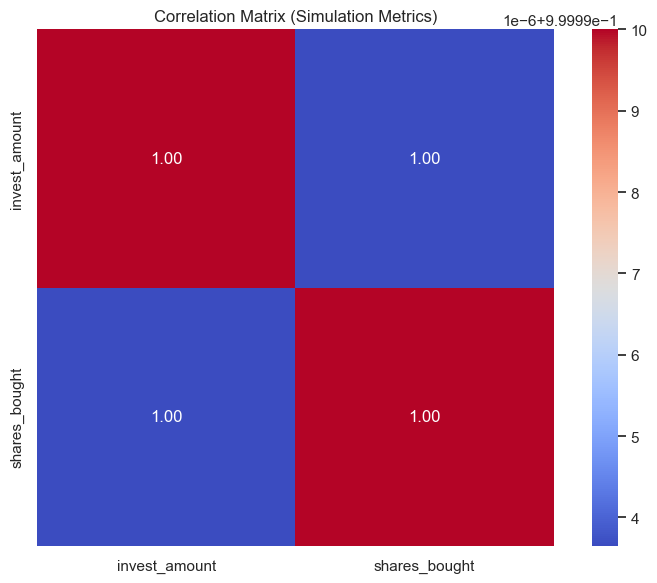

,count,sum,mean,median
ticker,,,,
A010420,5,-47649,-9529.8,0.0


In [10]:
if simulation_df.empty:
    print("Simulation DataFrame empty; skip descriptive statistics.")
else:
    display(simulation_df.describe(include="all").transpose())

    grouped_summary = (
        simulation_df.groupby("ticker")["invest_amount"].agg([
            ("trades", "count"),
            ("invest_total", "sum"),
            ("invest_mean", "mean"),
        ])
    )
    display(grouped_summary.sort_values("invest_total", ascending=False))

    numeric_cols = simulation_df.select_dtypes(include=[np.number])
    if not numeric_cols.empty:
        corr = numeric_cols.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
        plt.title("Correlation Matrix (Simulation Metrics)")
        plt.tight_layout()
        plt.show()

if revenue_df.empty:
    print("Revenue DataFrame empty; skipping revenue stats.")
else:
    revenue_summary = revenue_df.groupby("ticker")["revenue"].agg(["count", "sum", "mean", "median"])
    display(revenue_summary.sort_values("sum", ascending=False))

    if "profit_pct" in revenue_df.columns and revenue_df["profit_pct"].notna().any():
        profit_stats = revenue_df["profit_pct"].describe(percentiles=[0.25, 0.5, 0.75])
        display(profit_stats.to_frame(name="profit_pct"))

## 6. Run Statistical Tests
Evaluate whether revenues differ significantly from zero and compare profitability between tickers using SciPy hypothesis tests.

In [11]:
stat_test_results: list[dict[str, Any]] = []

if revenue_df.empty:
    print("Revenue data unavailable; skipping hypothesis tests.")
else:
    revenues = revenue_df["revenue"].dropna()
    if len(revenues) > 1:
        t_stat, p_value = stats.ttest_1samp(revenues, popmean=0)
        stat_test_results.append({
            "test": "one-sample t-test",
            "statistic": t_stat,
            "p_value": p_value,
            "n": len(revenues),
        })
        print(f"One-sample t-test vs zero revenue: t={t_stat:.3f}, p={p_value:.4f}, n={len(revenues)}")
    else:
        print("Not enough revenue observations for t-test.")

    if "profit_pct" in revenue_df.columns:
        groups = [
            grp.dropna().values
            for _, grp in revenue_df.groupby("ticker")["profit_pct"]
            if grp.dropna().shape[0] > 1
        ]
        if len(groups) >= 2:
            f_stat, p_value = stats.f_oneway(*groups)
            stat_test_results.append({
                "test": "one-way ANOVA (profit_pct by ticker)",
                "statistic": f_stat,
                "p_value": p_value,
                "groups": len(groups),
            })
            print(f"ANOVA across tickers (profit_pct): F={f_stat:.3f}, p={p_value:.4f}, groups={len(groups)}")
        else:
            print("Not enough ticker groups for ANOVA.")

if stat_test_results:
    display(pd.DataFrame(stat_test_results))

One-sample t-test vs zero revenue: t=-0.758, p=0.4908, n=5
Not enough ticker groups for ANOVA.


,test,statistic,p_value,n
0,one-sample t-test,-0.757793,0.490767,5


## 7. Generate Distribution Charts
Visualise the distributions of trade revenues and holding durations with histograms, KDE curves, and box plots.

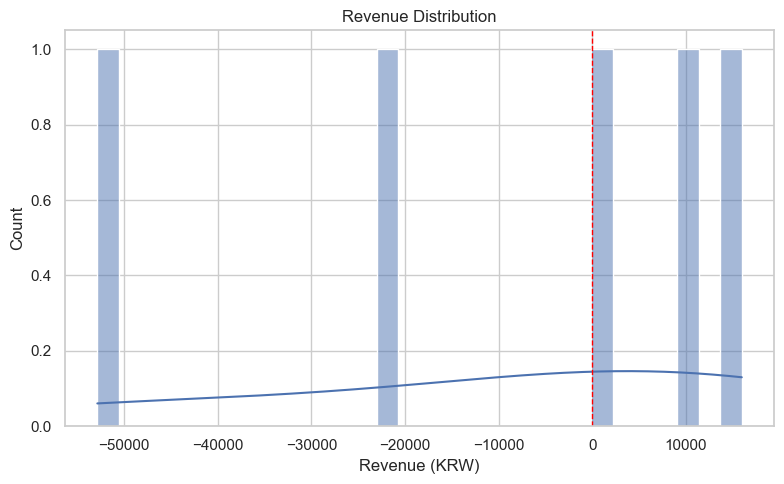

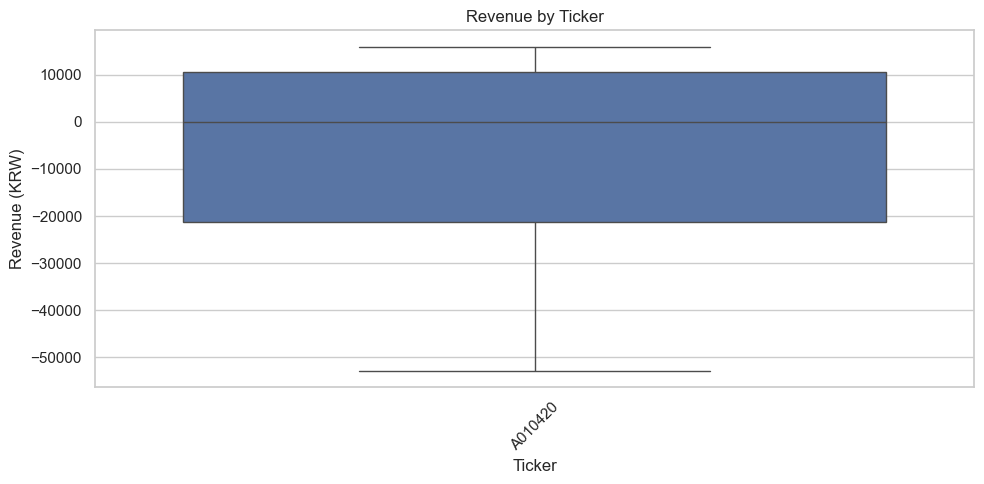

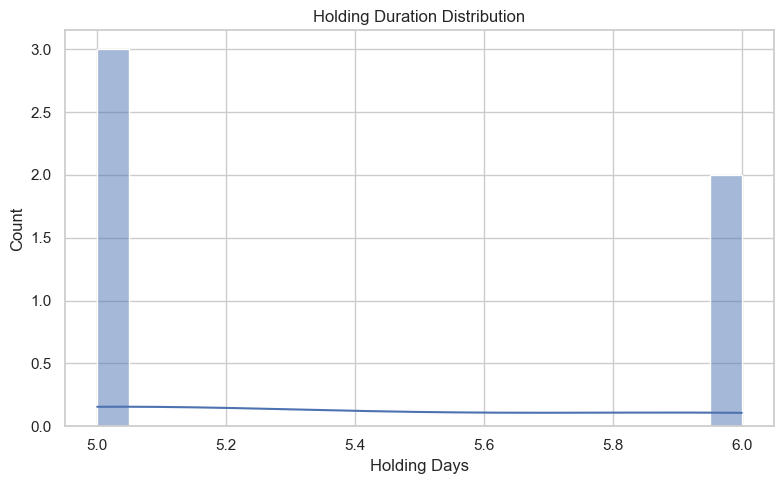

In [12]:
if revenue_df.empty:
    print("Revenue data unavailable; skipping distribution plots.")
else:
    plt.figure(figsize=(8, 5))
    sns.histplot(revenue_df["revenue"], kde=True, bins=30)
    plt.axvline(0, color="red", linestyle="--", linewidth=1)
    plt.title("Revenue Distribution")
    plt.xlabel("Revenue (KRW)")
    plt.tight_layout()
    plt.show()

    if "profit_pct" in revenue_df.columns and revenue_df["profit_pct"].notna().any():
        plt.figure(figsize=(8, 5))
        sns.kdeplot(revenue_df["profit_pct"].dropna(), shade=True)
        plt.title("Profit Percentage KDE")
        plt.xlabel("Profit %")
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=revenue_df, x="ticker", y="revenue")
    plt.title("Revenue by Ticker")
    plt.xlabel("Ticker")
    plt.ylabel("Revenue (KRW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if holdings_df.empty:
    print("Holdings data unavailable; skipping holding duration plots.")
else:
    if "holding_days" in holdings_df.columns and holdings_df["holding_days"].notna().any():
        plt.figure(figsize=(8, 5))
        sns.histplot(holdings_df["holding_days"].dropna(), kde=True, bins=20)
        plt.title("Holding Duration Distribution")
        plt.xlabel("Holding Days")
        plt.tight_layout()
        plt.show()

## 8. Create Comparative Visualizations
Build time-series and cross-sectional plots to compare performance across tickers and simulation dates.

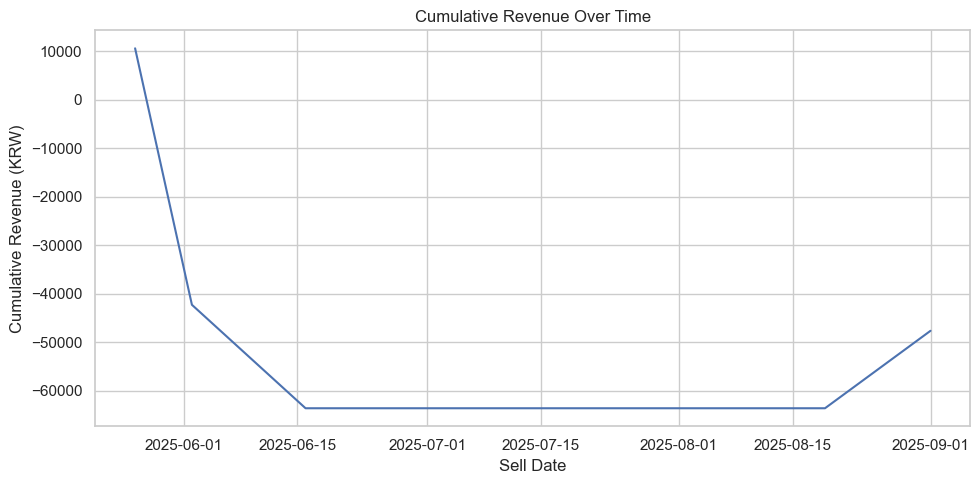

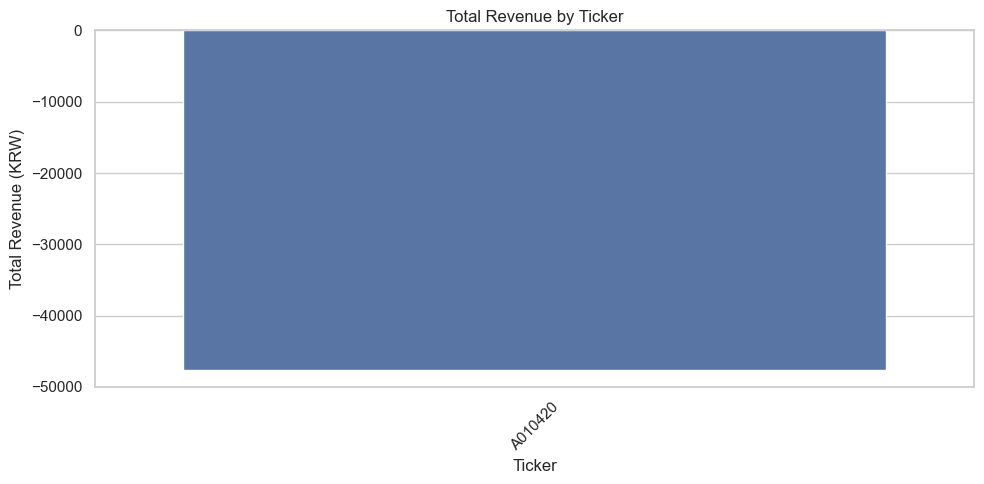

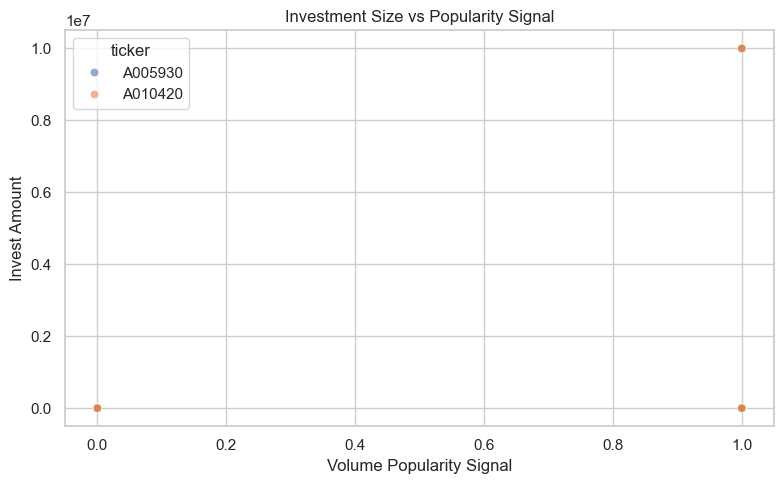

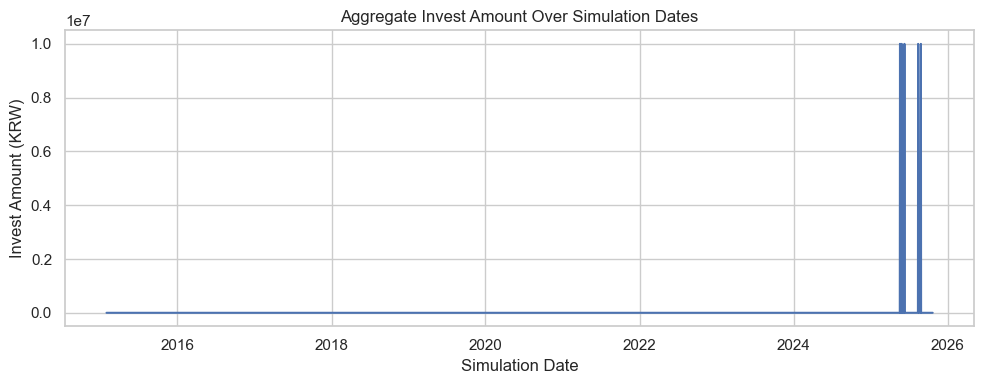

In [13]:
if revenue_df.empty:
    print("Revenue data unavailable; skipping comparative visuals.")
else:
    revenue_by_date = (
        revenue_df.groupby("sell_date")["revenue"].sum().sort_index().cumsum().rename("cumulative_revenue")
    )
    plt.figure(figsize=(10, 5))
    plt.plot(revenue_by_date.index, revenue_by_date.values)
    plt.title("Cumulative Revenue Over Time")
    plt.xlabel("Sell Date")
    plt.ylabel("Cumulative Revenue (KRW)")
    plt.tight_layout()
    plt.show()

    revenue_per_ticker = revenue_df.groupby("ticker")["revenue"].sum().sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=revenue_per_ticker.index, y=revenue_per_ticker.values)
    plt.title("Total Revenue by Ticker")
    plt.xlabel("Ticker")
    plt.ylabel("Total Revenue (KRW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if simulation_df.empty:
    print("Simulation data unavailable; skipping scatter plots.")
else:
    if {"invest_amount", "popularity"}.issubset(simulation_df.columns):
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=simulation_df, x="popularity", y="invest_amount", hue="ticker", alpha=0.6)
        plt.title("Investment Size vs Popularity Signal")
        plt.xlabel("Volume Popularity Signal")
        plt.ylabel("Invest Amount")
        plt.tight_layout()
        plt.show()

    if {"simuldate", "invest_amount"}.issubset(simulation_df.columns):
        invest_over_time = simulation_df.groupby("simuldate")["invest_amount"].sum().sort_index()
        plt.figure(figsize=(10, 4))
        plt.plot(invest_over_time.index, invest_over_time.values)
        plt.title("Aggregate Invest Amount Over Simulation Dates")
        plt.xlabel("Simulation Date")
        plt.ylabel("Invest Amount (KRW)")
        plt.tight_layout()
        plt.show()

## 9. Export Analysis Artifacts
Persist processed datasets, statistics, and test outcomes so they can be reused outside this notebook.

In [ ]:
export_prefix = (f"{target_prefix}_analysis" if "target_prefix" in locals() else "strategy01_analysis")
export_paths: dict[str, Path] = {}

if not simulation_df.empty:
    simulation_csv = analysis_output_dir / f"{export_prefix}_simulation.csv"
    simulation_df.to_csv(simulation_csv, index=False)
    export_paths["simulation_csv"] = simulation_csv

if not revenue_df.empty:
    revenue_csv = analysis_output_dir / f"{export_prefix}_revenue.csv"
    revenue_df.to_csv(revenue_csv, index=False)
    export_paths["revenue_csv"] = revenue_csv

    revenue_summary = revenue_df.groupby("ticker")["revenue"].agg(["count", "sum", "mean", "median"])
    summary_csv = analysis_output_dir / f"{export_prefix}_revenue_summary.csv"
    revenue_summary.to_csv(summary_csv)
    export_paths["revenue_summary_csv"] = summary_csv

if stat_test_results:
    stats_json = analysis_output_dir / f"{export_prefix}_stat_tests.json"
    with open(stats_json, "w", encoding="utf-8") as fh:
        json.dump(stat_test_results, fh, indent=2, default=str)
    export_paths["stat_tests_json"] = stats_json

if export_paths:
    print("Exported the following artifacts:")
    for label, path in export_paths.items():
        print(f"- {label}: {path}")
else:
    print("No artifacts were exported. Ensure data frames are populated before running this cell.")